# Определение неэффективных операторов в "Нупозвони"

## Введение

Телеком компании "Нупозвони" необходимо найти неэффективных операторов

**Цель** -- определение неэффективных сотрудников коллцентра по критериям:
- много пропущенных входящих вызовов,
- долгое ожидания ответа при входящих внешних вызовах,
- мало исходящих вывозов — в случае тех колл-центров, что специализируются на обзвонах, а не обработке входящих звонков.

**План**

*Ознакомление с данными. Предобработка.*
*Анализ данных*
- типы данных
- пропуски и аномалии

*Анализ эффективности операторов*
- посмотрю пропущенные звонки (смотрим пропущенные входящие),
- посмотрю время ожидания входящих звонков(сверх 5 минут),
- выделю неэффективных операторов (посмотрю их долю по отношению ко всем)

*Проверка гипотез*
- Время ожидания ответа на входящий звонок зависит от тарифного плана
- Эффективность работы операторов в понедельник отличается от эффективности по всем другим дням. 

*Вывод*

### Ознакомление с данными. Предобработка

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import scipy
import datetime


#### Выгрузка и изучение данных

In [2]:
#открою таблицу с данными по операторам
try:
    data_st = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_dataset.csv')
except:
    data_st = pd.read_csv('/datasets/telecom_dataset.csv')

In [3]:
 data_st.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [4]:
#посмотрю общую информацию о таблице
data_st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [5]:
#открою таблицу с данными по клиентам
try:
    data_client = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_clients.csv')
except:
    data_client = pd.read_csv('/datasets/telecom_clients.csv')

In [6]:
#посмотрю общую информацию о таблице
data_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


Общий вывод:

*датасет data_st*
 - состоит из 53 902 строк,
 - есть пропуски данных в operator_id, internal,
 - тип данных в operator_id float
 
 *датасет data_client*
 - состоит из 732 строк,
 - типы даннных в порядке,
 - пропусков нет.
 

#### Предобработка данных

#### Поиск и обработка дубликатов

In [7]:
#посмотрю, сколько дубликатов в каждм датасете

print('Количество дубликатов в таблице data_st:', data_st.duplicated().sum())
print('Количество дубликатов в датасете data_client:', data_client.duplicated().sum())

Количество дубликатов в таблице data_st: 4900
Количество дубликатов в датасете data_client: 0


In [8]:
#посчитаю долю дубликатов
print('Доля дубликатов в данных',(4900/53902)*100)

Доля дубликатов в данных 9.090571778412675


Дубликаты есть в таблице с данными по операторам, удалю их, так как их доля 9% 

In [9]:
#удаление дубликатов в data_st
data_st.drop_duplicates(inplace = True)

In [10]:
#проверю, все ли сработало
print('Количество дубликатов в таблице data_st:', data_st.duplicated().sum())

Количество дубликатов в таблице data_st: 0


In [11]:
#приведу столбец с датой к нужному типу
data_client['date_start'] = pd.to_datetime(data_client['date_start'], format='%Y-%m-%d')

In [12]:
#выделю столбец с днем совершения транзакции, день пригодится в дальнейшем анализе
def split_date(df):
    '''
    Функция приведения даты в тип данных datetime без учета времени
    
    '''
    date = df['date'].split()[0]
    date = pd.to_datetime(date, format='%Y-%m-%d')
    return date

In [13]:
 data_st['day'] = data_st.apply(split_date, axis=1)

In [14]:
data_st.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,day
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,2019-08-04
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,2019-08-05
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,2019-08-05
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,2019-08-05
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,2019-08-05


#### Поиск и обработка пропусков в данных

In [15]:
#посмотрим, где есть пропуски
data_st.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49002 entries, 0 to 53901
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49002 non-null  int64         
 1   date                 49002 non-null  object        
 2   direction            49002 non-null  object        
 3   internal             48892 non-null  object        
 4   operator_id          41546 non-null  float64       
 5   is_missed_call       49002 non-null  bool          
 6   calls_count          49002 non-null  int64         
 7   call_duration        49002 non-null  int64         
 8   total_call_duration  49002 non-null  int64         
 9   day                  49002 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 3.8+ MB


In [16]:
#выделю часть с пропусками в operator_id
data_st_Nan = data_st[data_st['operator_id'].isna() == True]

In [17]:
data_st = data_st[data_st['operator_id'].isna() == False]

In [18]:
data_st.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41546 entries, 1 to 53899
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              41546 non-null  int64         
 1   date                 41546 non-null  object        
 2   direction            41546 non-null  object        
 3   internal             41491 non-null  object        
 4   operator_id          41546 non-null  float64       
 5   is_missed_call       41546 non-null  bool          
 6   calls_count          41546 non-null  int64         
 7   call_duration        41546 non-null  int64         
 8   total_call_duration  41546 non-null  int64         
 9   day                  41546 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 3.2+ MB


In [19]:
data_st[data_st['internal'].isna() == True].head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,day
1924,166406,2019-09-02 00:00:00+03:00,in,NaN,879898.0,False,1,2,9,2019-09-02
6210,166541,2019-09-26 00:00:00+03:00,in,NaN,908960.0,False,1,393,423,2019-09-26
6216,166541,2019-09-26 00:00:00+03:00,in,NaN,908958.0,False,2,547,612,2019-09-26
7528,166604,2019-11-01 00:00:00+03:00,in,NaN,893402.0,False,1,94,117,2019-11-01
8650,166658,2019-09-24 00:00:00+03:00,in,NaN,890404.0,False,1,150,157,2019-09-24


In [20]:
print('Пропуски в internal',(((41546-41491)/41546)*100))

Пропуски в internal 0.1323833822750686


Удалю пропуски в internal их менее 1% и их возникновение не ясно

In [21]:
data_st = data_st.dropna(axis=0, how='any')

In [22]:
data_st.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41491 entries, 1 to 53899
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              41491 non-null  int64         
 1   date                 41491 non-null  object        
 2   direction            41491 non-null  object        
 3   internal             41491 non-null  object        
 4   operator_id          41491 non-null  float64       
 5   is_missed_call       41491 non-null  bool          
 6   calls_count          41491 non-null  int64         
 7   call_duration        41491 non-null  int64         
 8   total_call_duration  41491 non-null  int64         
 9   day                  41491 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 3.2+ MB


In [23]:
#изменю тип данных в operator_id на целочисленные
data_st['operator_id'] = data_st['operator_id'].astype('int64')

**Общий вывод:**

*На данном этапе я:*

- выделила столбец с днем,
- изменила тип данных в столбце operator_id и date_start,
- обработала дубликаты и пропуски

### Исследовательский анализ данных

#### Датасет data_st

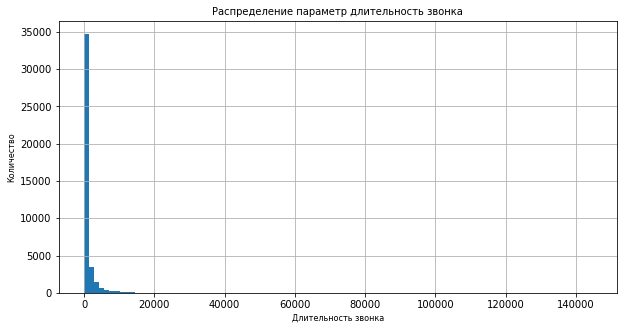

In [24]:
#посмотрим график по длительности звонка
data_st['call_duration'].hist(bins=100, figsize=(10,5))
plt.title('Распределение параметр длительность звонка', fontsize=10)
plt.xlabel('Длительность звонка', fontsize=8)
plt.ylabel('Количество', fontsize=8)
plt.show()

In [25]:
data_st['call_duration'].describe()

count     41491.000000
mean       1010.940011
std        4066.666485
min           0.000000
25%           0.000000
50%         106.000000
75%         772.000000
max      144395.000000
Name: call_duration, dtype: float64

Максимальная длительность звонка 144 395, такое значение нереалистично и, возможно, имеет место быть техническая проблема записи и хранения данных или телефонии.

Среднняя длителньость звонка 1010

Есть звонки по 0 сек

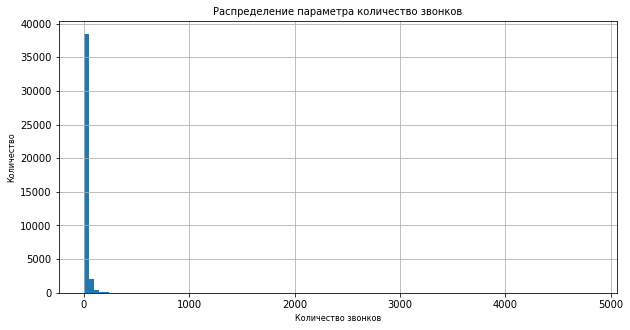

In [26]:
#посмотрим график по количеству звонков
data_st['calls_count'].hist(bins=100, figsize=(10,5))
plt.title('Распределение параметра количество звонков', fontsize=10)
plt.xlabel('Количество звонков', fontsize=8)
plt.ylabel('Количество', fontsize=8)
plt.show()

In [27]:
data_st['calls_count'].describe()

count    41491.000000
mean        16.921381
std         59.786187
min          1.000000
25%          1.000000
50%          4.000000
75%         14.000000
max       4817.000000
Name: calls_count, dtype: float64

Параметр количество звонков:

Самое большое количество звонков 4817

Среднее кол-во звонков 17

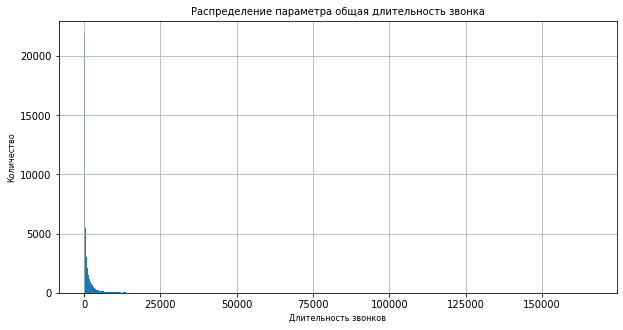

In [28]:
#посмотрим график по общей длительности звонков

data_st['total_call_duration'].hist(bins=500, figsize=(10,5))
plt.title('Распределение параметра общая длительность звонка', fontsize=10)
plt.xlabel('Длительность звонков', fontsize=8)
plt.ylabel('Количество', fontsize=8)
plt.show()

In [29]:
data_st['total_call_duration'].describe()

count     41491.000000
mean       1323.153238
std        4788.953155
min           0.000000
25%          67.000000
50%         289.000000
75%        1107.000000
max      166155.000000
Name: total_call_duration, dtype: float64

Общая длительность звонков:

- максимальная -- 166 155

- средняя длительность 1323 сек

Максимальная длительность звонка 144 395, такое значение нереалистично и, возможно, имеет место быть техническая проблема записи и хранения данных или телефонии.

Среднняя длителньость звонка 1010

Есть звонки по 0 сек
Далее почищу выбросы

In [30]:
#функция для чистки данных
def create_boxplots(df, parametrs):
    for parametr, parametr_synonym in parametrs.items():
        df.boxplot(parametr).set(title='Распределение данных', ylabel=parametr_synonym)
        plt.show()
        df = df[df[parametr] <= df[parametr].quantile(0.97)]
    return df

In [31]:
variables = {'calls_count':'Количество звонков', 'call_duration':'Длительность звонков (без учета времени ожидания)', 'total_call_duration':'Длительность звонков (с учетом времени ожидания)'}

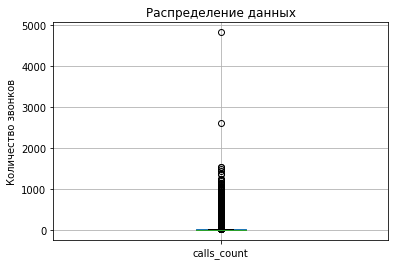

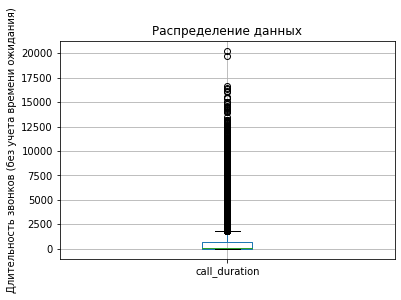

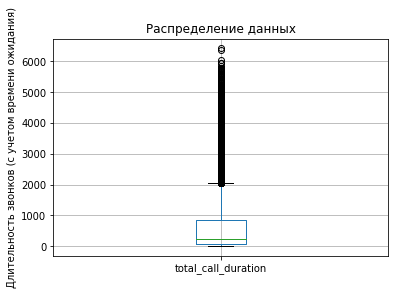

In [32]:
data_st = create_boxplots(data_st, variables)

Данные после очистки

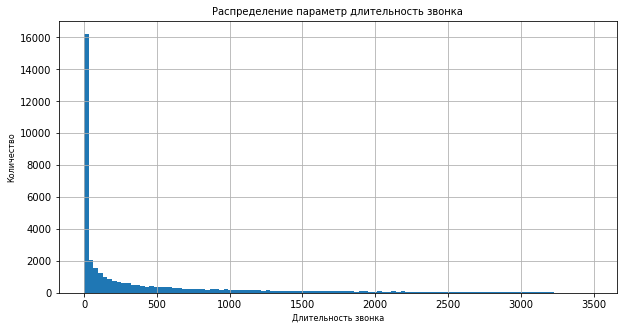

In [33]:
data_st['call_duration'].hist(bins='auto', figsize=(10,5))
plt.title('Распределение параметр длительность звонка', fontsize=10)
plt.xlabel('Длительность звонка', fontsize=8)
plt.ylabel('Количество', fontsize=8)
plt.show()

In [34]:
data_st['call_duration'].describe()

count    37893.000000
mean       415.497717
std        675.242558
min          0.000000
25%          0.000000
50%         77.000000
75%        538.000000
max       3484.000000
Name: call_duration, dtype: float64

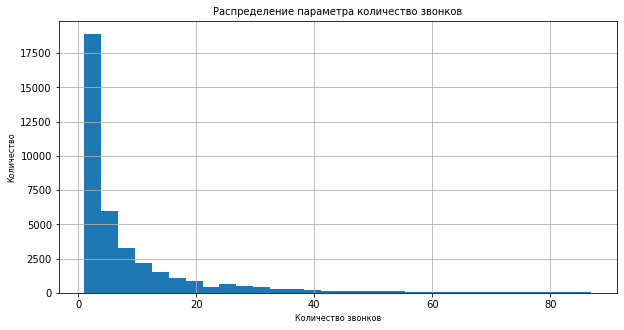

In [35]:
data_st['calls_count'].hist(bins=30, figsize=(10,5))
plt.title('Распределение параметра количество звонков', fontsize=10)
plt.xlabel('Количество звонков', fontsize=8)
plt.ylabel('Количество', fontsize=8)
plt.show()

In [36]:
data_st['calls_count'].describe()

count    37893.000000
mean         8.555881
std         12.520435
min          1.000000
25%          1.000000
50%          4.000000
75%         10.000000
max         87.000000
Name: calls_count, dtype: float64

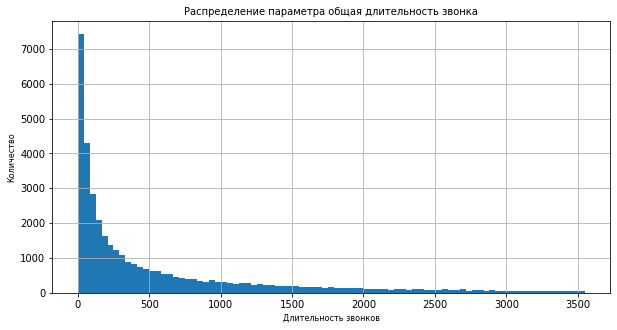

In [37]:
data_st['total_call_duration'].hist(bins='auto', figsize=(10,5))
plt.title('Распределение параметра общая длительность звонка', fontsize=10)
plt.xlabel('Длительность звонков', fontsize=8)
plt.ylabel('Количество', fontsize=8)
plt.show()

In [38]:
data_st['total_call_duration'].describe()

count    37893.000000
mean       568.347901
std        758.843437
min          0.000000
25%         59.000000
50%        229.000000
75%        766.000000
max       3550.000000
Name: total_call_duration, dtype: float64

Итак, теперь средняя длительность звонка составляет 229 секунд, самый длительнный звонок 3550 сек (около 60 минут - такое может быть, в зависимости от задач кол-центра).

Количество звонков в день максимальное 87, среднее 8. Здесь пока рано делать выводы об операторах и их эффективности.

Странно малое кол-во звонков.

In [39]:
#посмотрю диапазон дат
print('Диапазон дат в датасете c', data_st['day'].min(), 'по', data_st['day'].max())

Диапазон дат в датасете c 2019-08-02 00:00:00 по 2019-11-28 00:00:00


#### Таблица data_client

In [40]:
data_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


In [41]:
#посмотрим как распределены тарифы
data_client['tariff_plan'].value_counts()


C    395
B    261
A     76
Name: tariff_plan, dtype: int64

In [42]:
print('Диапазон дат в датасете c', data_client['date_start'].min(),'по', data_client['date_start'].max())


Диапазон дат в датасете c 2019-08-01 00:00:00 по 2019-10-31 00:00:00


### Анализ эффективности операторов

In [43]:
#объединю таблицу стаф и клиент
total_table = data_st.merge(data_client, on='user_id', how='left')
total_table = total_table.drop('date', axis=1)
total_table.head()

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,day,tariff_plan,date_start
0,166377,out,True,880022,True,3,0,5,2019-08-05,B,2019-08-01
1,166377,out,True,880020,True,1,0,1,2019-08-05,B,2019-08-01
2,166377,out,True,880020,False,1,10,18,2019-08-05,B,2019-08-01
3,166377,out,False,880022,True,3,0,25,2019-08-05,B,2019-08-01
4,166377,out,False,880020,False,2,3,29,2019-08-05,B,2019-08-01


In [44]:
#посчитаю сколько всего звонков по каждому оператору
total_calls_by_operator = total_table.groupby(['operator_id']).agg(sum)
total_calls_by_operator.head()

,user_id,is_missed_call,calls_count,call_duration,total_call_duration
operator_id,,,,,
879896,18471066,47,552,30343,39310
879898,30452298,89,3651,62101,127735
880020,3327540,6,45,2245,2525
880022,11646390,29,197,15147,18925
880026,30114237,87,2189,149891,171872


#### Критерий эффективности -- пропущенные звонки

Буду смотреть пропущенные входящие звонки. В отрасли нормальноу значение пропущенных звонков от 5 до 8%. Возьмем 8%

In [46]:
#выделю срез только с пропущенными входящими вызовами
abondement_calls = total_table[(total_table['direction'] == 'in') & (total_table['is_missed_call'] == True)]
abondement_calls.head(5)

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,day,tariff_plan,date_start
568,166405,in,False,882684,True,1,0,7,2019-08-19,B,2019-08-02
569,166405,in,False,882686,True,1,0,5,2019-08-19,B,2019-08-02
590,166405,in,False,882684,True,1,0,14,2019-08-24,B,2019-08-02
606,166405,in,False,882686,True,2,0,50,2019-08-28,B,2019-08-02
688,166405,in,False,882686,True,1,0,8,2019-09-09,B,2019-08-02


In [47]:
def piv_tab_creator(data, p_groupby, p_agg, p_rename, p_sort, a_sort):
    '''
    Функция для создания сводных таблиц:
    
    data = датафрейм
    p_groupby = параметр группировки
    p_agg = параметр агрегации и метод (формат {'':''})
    p_rename = старое наименование столбца для переименования и новое (формат {'':''})
    p_sort = параметр сортировки
    a_sort = вид сортировки: True по возрастанию, False - по убыванию
    
    '''
    
    if p_rename == 0:
        data = (data
                .groupby(p_groupby)
                .agg(p_agg)
                .reset_index()
                .sort_values(by=p_sort, ascending=a_sort))
    else:
        data = (data
                .groupby(p_groupby)
                .agg(p_agg)
                .reset_index()
                .rename(columns=p_rename)
                .sort_values(by=p_sort, ascending=a_sort))
    
    return data

In [48]:
#таблица с пропущенными входящими вызовами
abondement_calls = piv_tab_creator(data=abondement_calls, p_groupby=['user_id', 'operator_id'], p_agg={'calls_count':'sum'}, p_rename={'calls_count':'a_calls'}, p_sort='a_calls', a_sort=False)
abondement_calls.head(10)

,user_id,operator_id,a_calls
90,167071,913942,52
177,167977,944226,30
215,168252,940588,30
23,166582,885890,26
208,168187,937956,24
173,167977,944216,24
185,168062,951508,21
22,166582,885876,20
175,167977,944220,18
220,168252,940630,17


In [49]:
#табличка с обими звонками и пропущенными
mega_total_table = total_calls_by_operator.merge(abondement_calls, on='operator_id', how='left')
mega_total_table.head()

,operator_id,user_id_x,is_missed_call,calls_count,call_duration,total_call_duration,user_id_y,a_calls
0,879896,18471066,47,552,30343,39310,NaN,NaN
1,879898,30452298,89,3651,62101,127735,NaN,NaN
2,880020,3327540,6,45,2245,2525,NaN,NaN
3,880022,11646390,29,197,15147,18925,NaN,NaN
4,880026,30114237,87,2189,149891,171872,NaN,NaN


In [50]:
mega_total_table['share_of_abondement_calls'] = (mega_total_table['a_calls']/mega_total_table['calls_count'])*100
mega_total_table.head(5)

,operator_id,user_id_x,is_missed_call,calls_count,call_duration,total_call_duration,user_id_y,a_calls,share_of_abondement_calls
0,879896,18471066,47,552,30343,39310,NaN,NaN,NaN
1,879898,30452298,89,3651,62101,127735,NaN,NaN,NaN
2,880020,3327540,6,45,2245,2525,NaN,NaN,NaN
3,880022,11646390,29,197,15147,18925,NaN,NaN,NaN
4,880026,30114237,87,2189,149891,171872,NaN,NaN,NaN


In [51]:
share_of_calls_1 = pd.pivot_table(mega_total_table, index='operator_id', values='share_of_abondement_calls')
top_share_of_calls_2=share_of_calls_1.sort_values(by='share_of_abondement_calls')
top_share_of_calls_2.head()

,share_of_abondement_calls
operator_id,
891414,0.045331
899082,0.046168
901884,0.046275
939224,0.072833
917852,0.073638


In [52]:
top_share_of_calls_3 = top_share_of_calls_2.sort_values(by='share_of_abondement_calls')
top_share_of_calls_3.tail(20)

,share_of_abondement_calls
operator_id,
918888,9.090909
926872,9.677419
906392,9.859155
911142,10.000000
944226,10.948905
911102,11.111111
894614,12.500000
937368,12.500000
940588,12.820513


In [53]:
bad_outliers = top_share_of_calls_3.loc[top_share_of_calls_3['share_of_abondement_calls'] > 8]
bad_outliers.head()

,share_of_abondement_calls
operator_id,
934076,9.090909
918888,9.090909
926872,9.677419
906392,9.859155
911142,10.000000


In [54]:
bad_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 934076 to 913886
Data columns (total 1 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   share_of_abondement_calls  21 non-null     float64
dtypes: float64(1)
memory usage: 336.0 bytes


In [55]:
24/1089*100

2.203856749311295

Итак, у нас есть 24 оператора неэффективных оператора по критерию "Пропущенные входящие звонки". Доля пропущенных входящих звонков у этих операторов более 8%. Таких операторов 2%

5-8 % -- это рекомендуемый бенчмарк пропущенных звонков в коллцентре по стандарту COPC, соответственно, если у оператора доля пропущенных звонков более 8 % - он неэффективный по этому критерию.

 #### Критерий эффективности -- ожидание ответа

Будем анализировать входящие звонки (непропущенные) 

In [56]:
total_table['waiting_time'] = total_table['total_call_duration'] - total_table['call_duration']
waiting_duration = total_table.query('is_missed_call == False and direction=="in" and internal==False')
waiting_duration.sample(5)

,user_id,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,day,tariff_plan,date_start,waiting_time
971,166405,in,False,882690,False,4,527,779,2019-10-29,B,2019-08-02,252
19040,167158,in,False,907502,False,1,23,51,2019-10-03,A,2019-09-04,28
35509,168187,in,False,937956,False,14,1295,1306,2019-11-28,A,2019-10-16,11
36033,168252,in,False,940624,False,18,1713,1806,2019-11-12,A,2019-10-17,93
29236,167852,in,False,932798,False,5,553,598,2019-11-01,C,2019-10-02,45


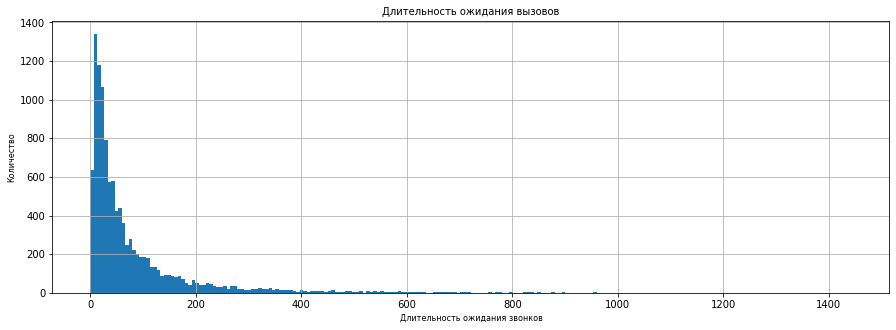

In [57]:
waiting_duration['waiting_time'].hist( bins='auto',figsize=(15,5))

plt.title('Длительность ожидания вызовов', fontsize=10)
plt.xlabel('Длительность ожидания звонков', fontsize=8)
plt.ylabel('Количество', fontsize=8)
plt.show()

In [58]:
#таблица со средним временем ожмдания вызова
avg_wait_duration = pd.pivot_table(waiting_duration, index='operator_id', values='waiting_time', aggfunc='mean')

avg_wait_duration.head()

,waiting_time
operator_id,
879896,27.333333
879898,29.875000
880020,7.714286
880022,14.000000
880026,7.944444


Будем смотреть, чтобы среднее время ожидания не превышало 300 сек (или 5 минут).

In [77]:
bad_outliers_wait = avg_wait_duration.loc[avg_wait_duration['waiting_time'] > 300]
bad_outliers_wait.head()

,waiting_time
operator_id,
882688,336.500000
882690,349.100000
906076,611.500000
906404,320.843750
906406,421.842105


In [78]:
bad_outliers_wait.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 882688 to 958460
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   waiting_time  15 non-null     float64
dtypes: float64(1)
memory usage: 240.0 bytes


Вот и наши операторы, время ожидания вызовов у которых превышает 300 секунд (или 5 минут). Их 15. Или 1,37%

Посмотрю, есть ли среди операторов из bad_outliers те, кто попал в bad_outliers_wait.

In [79]:
very_bad_outliers = bad_outliers_wait.merge(bad_outliers, on='operator_id', how='left')
very_bad_outliers.head()


,waiting_time,share_of_abondement_calls
operator_id,,
882688,336.500000,NaN
882690,349.100000,NaN
906076,611.500000,NaN
906404,320.843750,NaN
906406,421.842105,NaN


In [80]:
very_bad_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 882688 to 958460
Data columns (total 2 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   waiting_time               15 non-null     float64
 1   share_of_abondement_calls  0 non-null      float64
dtypes: float64(2)
memory usage: 360.0 bytes


Операторы неэффективны по разным признакам: 

- 24 оператора имеют долю пропущенных входящих звонков более 8%
- 15 операторов имеют время ожидания входящего внешнего  звонка более 300 секунд 


Неэффективный оператор обладает одним из критериев:

- имеет долю пропущеных входящих более 8% 
- среднее время ожидания входящего звонка более 300 секунд

Неэффективны 15 операторов из таблицы very_bad_outliers, по критерию врмени ожидания ответа

Неээфективны 24 оператора из таблицы bad_outliers по количеству входящих пропущенных. 

Всего неээфективных операторов 39 (или 3,6 %) 

Что имеется в виду под "Насколько они распространены по коллцентрам"? и как это посмотреть?


## Проверка гипотез

### Время ожидания зависит от тарифного плана

Формулировка гипотез:

H0 -  *Время ожидания ответа не зависит от тарифного плана*

H1 -  *Время ожидания ответа зависит от тарифного плана*

Тест предназначен для проверки равенства средних нескольких выборок и поможет определить значимость различий по нескольким группам. Критерий Манна-Уитни

In [65]:
tariff_A = total_table.query('tariff_plan == "A"')['waiting_time']
len(tariff_A)

10449

In [66]:
tariff_B = total_table.query('tariff_plan == "B"')['waiting_time']
len(tariff_B)

13556

In [67]:
tariff_C = total_table.query('tariff_plan == "C"')['waiting_time']
len(tariff_C)

13888

In [68]:
alpha = 0.05
results = scipy.stats.kruskal(tariff_A, tariff_B, tariff_C)

In [69]:
print('p-значение', results.pvalue)

p-значение 1.0554173100834003e-27


In [70]:
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу, время ожидания ответа не зависит от тарифного плана')

Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу. Есть основания предполагать, что время ожидания ответа зависит от тарифного плана

### Эффективность работы операторов в понедельник отличается от эффективности по всем другим дням.

Сформулирую гипотезы: 


*H0 - эффективнось работы операторов в понедельник не отличается от эффективности по всем другим дням*

*H1 - эффективность работы операторов в понедельник отличается от эффективности по всем другим дням*


Эффективность -- количество принятых входящих вызовов.

Буду использовать t-test с поправкой equal_var = False, так как выборки  разного размера или есть сомнения, что дисперсии у совокупностей одинаковые,

In [71]:
#добавлю название дня недели
total_table['weekday'] = total_table['day'].dt.day_name()

In [72]:
#первый фильтр -- день недели понедельник, входящий и принятый вызов.
filter_1 = total_table.query('(weekday=="Monday") and (direction == "in") and (is_missed_call == False)')['calls_count']

In [73]:
#второй фильтр -- день недели не понедельник, входящий и принятый вызов.
filter_2 = total_table.query('(weekday!="Monday") and (direction == "in") and (is_missed_call == False)')['calls_count']

In [74]:
alpha = 0.05
results = scipy.stats.ttest_ind(filter_1, filter_2, equal_var=False)

In [75]:
print('p-значение', results.pvalue)


p-значение 0.8462151649841072


In [76]:
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу: эффективнось работы операторов в понедельник не отличается от эффективности по всем другим дням')

Не получилось отвергнуть нулевую гипотезу: эффективнось работы операторов в понедельник не отличается от эффективности по всем другим дням


Нет оснований утверждать, что эффективность работы операторов в понедельник отличается от эффективности по всем другим дням

## Вывод

На первом этапе я исследовала общую информацию о таблицах:

*датасет data_st*
 - состоит из 53 902 строк,
 - есть пропуски данных в operator_id, internal,
 - тип данных в operator_id float
 
 *датасет data_client*
 - состоит из 732 строк,
 - типы даннных в порядке,
 - пропусков нет.
 
 
 
 *Подготовила данные к дальнейшему анализу:*

- выделила столбец с днем,
- изменила тип данных в столбце operator_id и date_start,
- обработала дубликаты и пропуски


*Провела исследовательский анализ данных в котором заметила, что:*
 - Максимальная длительность звонка 144 395, такое значение нереалистично и, возможно, имеет место быть техническая проблема записи и хранения данных или телефонии.

- Среднняя длителньость звонка 1010

- Есть звонки по 0 сек

*Посмотрела на эффективность операторов по разным критериям и выяснила, что*
- есть 24 оператора неэффективных оператора по критерию "Пропущенные входящие звонки".
- доля пропущенных входящих звонков у этих операторов более 8%. Таких операторов 2%.
- 15 операторов, время ожидания вызовов у которых превышает 300 секунд (или 5 минут).
- Таких операторов 1,37%


*Операторы неэффективны по разным признакам:*

- 24 оператора имеют долю пропущенных входящих звонков более 8%
- 15 операторов имеют время ожидания входящего внешнего  звонка более 300 секунд 


Рекомендации:
- углубить аналитику по операторам и их KPI,
- провести аудит систем хранения и агрегации данных.

Презентация по ссылке https://disk.yandex.ru/i/MoEQ5ykUbP1lhg

